Note: when using MKL set OMP_NUM_THREADS=1.

In [1]:
import glob
import itertools
import logging
from operator import attrgetter
import os
import pprint
import sys
import time

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.misc

import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist

import sklearn.utils

import mrfitty
from mrfitty.base import (
    AdaptiveEnergyRangeBuilder,
    InterpolatedSpectrumSet,
    ReferenceSpectrum,
)
from mrfitty.prediction_error_fit import PredictionErrorFitTask
from mrfitty.linear_model import NonNegativeLinearRegression

logging.basicConfig(level=logging.WARN)

In [2]:
src_path, _ = os.path.split(mrfitty.__path__[0])
sample_data_dir_path = os.path.join(src_path, 'example', 'arsenic')
print('sample data is installed at "{}"'.format(sample_data_dir_path))
os.path.exists(sample_data_dir_path)

sample data is installed at "/mnt/hgfs/Project/mr-fitty/src/example/arsenic"


True

Read all sample reference and unknown spectra.

In [3]:
sample_data_reference_glob = os.path.join(sample_data_dir_path, 'reference/*als_cal*.e')
print('sample data reference glob: {}'.format(sample_data_reference_glob))
sample_data_unknown_glob = os.path.join(sample_data_dir_path, 'unknown/*.e')
print('sample data unknown glob: {}'.format(sample_data_unknown_glob))

sample data reference glob: /mnt/hgfs/Project/mr-fitty/src/example/arsenic/reference/*als_cal*.e
sample data unknown glob: /mnt/hgfs/Project/mr-fitty/src/example/arsenic/unknown/*.e


In [4]:
sample_data_reference_set, _ = list(ReferenceSpectrum.read_all([sample_data_reference_glob]))
sample_data_reference_list = list(sample_data_reference_set)
print('sample data reference file count: {}'.format(len(sample_data_reference_list)))
sample_data_unknown_set, _ = list(ReferenceSpectrum.read_all([sample_data_unknown_glob]))
sample_data_unknown_list = sorted(list(sample_data_unknown_set), key=lambda s: s.file_name)
print('sample data unknown file count: {}'.format(len(sample_data_unknown_list)))

sample data reference file count: 20
sample data unknown file count: 16


What are the maximum and minimum reference energies?

In [5]:
reference_min_energy = np.max([r.data_df.index.values[0] for r in sample_data_reference_list])
reference_max_energy = np.min([r.data_df.index.values[-1] for r in sample_data_reference_list])
print('reference minimum energy: {:5.2f}'.format(reference_min_energy))
print('reference maximum energy: {:5.2f}'.format(reference_max_energy))

reference minimum energy: 11830.00
reference maximum energy: 12097.14


What are the maximum and minimum unknown spectrum energies?

In [6]:
min_energy = np.max([r.data_df.index.values[0] for r in sample_data_unknown_list])
max_energy = np.min([r.data_df.index.values[-1] for r in sample_data_unknown_list])
print('minimum energy: {:5.2f}'.format(min_energy))
print('maximum energy: {:5.2f}'.format(max_energy))

minimum energy: 11777.73
maximum energy: 12171.83


Plot one fit with training and testing points marked.

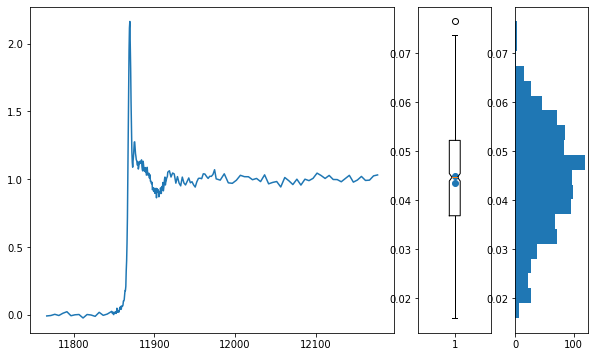

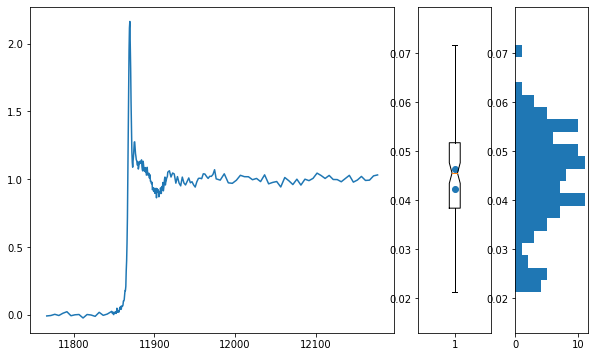

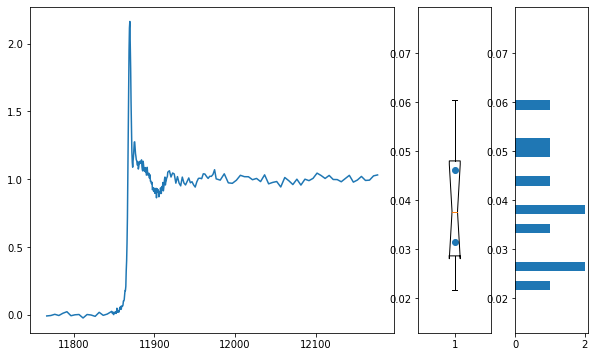

In [12]:
unknown_0 = sample_data_unknown_list[0]

fitter = PredictionErrorFitTask(
    ls=NonNegativeLinearRegression,
    reference_spectrum_list=sample_data_reference_list[0:3],
    unknown_spectrum_list=(unknown_0, ),
    energy_range_builder=AdaptiveEnergyRangeBuilder(),
    best_fits_plot_limit=0,
    component_count_range=(1,3+1)
)

fit_0, _ = fitter.fit(unknown_spectrum=sample_data_unknown_list[0])

normalized_C_p_list, model_residuals = fitter.calculate_prediction_error_list(fit_0, n_splits=3000)

# model_residuals looks like
#  NaN NaN 0.1 NaN 0.1 0.1 NaN
#  0.1 NaN 0.1 0.1 NaN NaN NaN
#  0.1 NaN NaN NaN 0.1 NaN 0.1

def classical_confidence_interval_of_mean(C_p_list):
    z_star = 1.96
    Z = z_star * (np.std(C_p_list)/np.sqrt(len(C_p_list)))
    mean_C_p = np.mean(C_p_list)
    lo = mean_C_p - Z
    hi = mean_C_p + Z
    return lo, hi
    
def three_plots(unknown, C_p_list, hist_ylim=None):
    plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(nrows=1, ncols=12)
    gs.update(wspace=1.0)
    ax_line = plt.subplot(gs[0, 0:8])
    ax_box = plt.subplot(gs[0, 8:10])
    ax_hist = plt.subplot(gs[0, 10:])

    if hist_ylim is None:
        pass
    else:
        ax_box.set_ylim(hist_ylim)
        ax_hist.set_ylim(hist_ylim)
    
    ci_mean_lo, ci_mean_hi = classical_confidence_interval_of_mean(C_p_list)
    
    ax_line.plot(unknown.data_df.index, unknown.data_df.norm)
    ax_box.boxplot(C_p_list, notch=True)
    ax_box.scatter((1, 1), (ci_mean_lo, ci_mean_hi))
    ax_hist.hist(C_p_list, orientation='horizontal', bins=20)

    return ax_line, ax_box, ax_hist

ax_line_1000, ax_box_1000, ax_hist_1000 = three_plots(unknown_0, normalized_C_p_list[:1000])
ax_line_100, ax_box_100, ax_hist_100 = three_plots(
    unknown_0, normalized_C_p_list[:100], hist_ylim=ax_hist_1000.get_ylim()
)
ax_line_1, ax_box_1, ax_hist_1 = three_plots(
    unknown_0, normalized_C_p_list[:10], hist_ylim=ax_hist_1000.get_ylim()
)

plt.show()

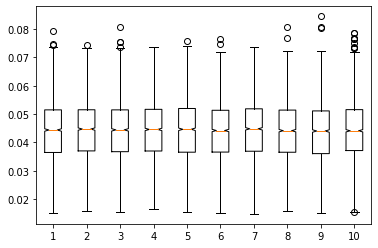

In [8]:
all_C_p_lists = []
for i in range(10):
    normalized_C_p_list, model_residuals = fitter.calculate_prediction_error_list(fit_0, n_splits=3000)
    all_C_p_lists.append(normalized_C_p_list)

plt.boxplot(all_C_p_lists, notch=True)
plt.show()

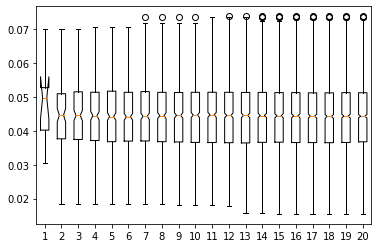

In [9]:
all_C_p_lists = []
normalized_C_p_list, model_residuals = fitter.calculate_prediction_error_list(fit_0, n_splits=2500)
for i in range(10, 2000, 100):
    all_C_p_lists.append(normalized_C_p_list[:i])

plt.boxplot(all_C_p_lists, notch=True)
plt.show()

(227, 1)


TypeError: hist() missing 1 required positional argument: 'x'

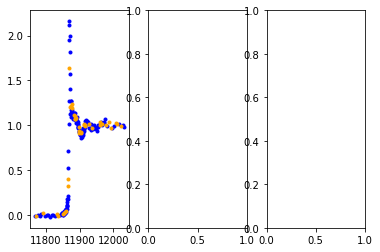

In [10]:
for i, (predicted_b, train_index, test_index) in enumerate(fitter.fit_and_predict(fit_0, n_splits=3)):
    #train_test_ndx = np.random.choice([0, 1], unknown_0.data_df.shape[0], p=[0.2, 0.8])
    #predicted_b, train_index, test_index = fitter.fit_and_predict(fit_0)
    print(unknown_0.data_df.shape)
    train_test_ndx = np.zeros((unknown_0.data_df.shape[0]))
    #print(train_test_ndx)
    #print(test_index)
    train_test_ndx[test_index] = 1
    f, ax = plt.subplots(1, 3)
    #ax[0].plot(unknown_0.data_df.index, unknown_0.data_df.norm)
    ax[0].scatter(
        unknown_0.data_df.index.values[train_index],
        unknown_0.data_df.norm.values[train_index],
        #c=train_test_ndx, # this was used before plotting a line
        c='blue',
        marker='.'
    )
    
    ax[0].scatter(
        unknown_0.data_df.index.values[test_index],
        unknown_0.data_df.norm.values[test_index],
        #c=train_test_ndx, # this was used before plotting a line
        c='orange',
        marker='.'
    )
    ax[1].hist()
    plt.show()